# Présentation du Projet 2 : Bornes de Recharches au bon endroit

Equipe : **AlgoKiller**

Membres de l'équipe : YAPI AHO LUC-AYMAR, ROUZOUMKA YANDANG ALEXIS

## Contexte du projet 


Ce projet porte sur la recherche d’une implantation idéale de bornes de recharches pour voitures électriques.
L’objectif est de localiser des zones d’implantation potentielles qui ne
nécessiteraient pas d’investissements majeurs sur le réseau. Autrement dit, en utilisant les capacités des
différents tronçons du réseau déjà disponibles. Pour cela, plusieurs données ont été mises à notre disposition.

1. Capacités du réseau basse tension projetées sur des portions de route
2. Trafic journalier sur les routes nationales du département 
3.  Densité de population par commune et évolution depuis 1968 
4.  Positions des bornes de recharge déjà implantées sur le domaine public



## Démarche adoptée

Pour résoudre la problématique posée, nous avons suivis la démarche suivante:

1. **Traitement des données**

Dans cette étape, nous avons effectué de nombreuses transformations sur nos jeux de données ( supression des doublons,regroupement, jointures, etc.) afin d'obtenir un jeu de données utilisable pour la partie de la modélisation.

2. **Modélisation à l'aide d'une méthode Kmeans basée sur Basés sur la pondération de variables explicatives**

Grâce à une Algorithme de Kmeans pondéré, nous déterminons l'emplacement des bornes potentielles en prenant en considération les différents énoncés dans le projet.

3. **Conclusion** 

On fait un bilan, sur la modélistion et les résultats obtenues.



## Partie 1 : Traitement des données

In [1]:
# Installation et chargement des modules nécessaires
# pip install geopandas 
from tqdm.notebook import tqdm
import geopandas as gpd
import pandas as pd

In [391]:
# chargement des données depuis la source
url1 = "https://github.com/rennesdatascience/datachallenge2023/raw/main/data/sujet-2/capa_route_35.geojson"
url2 = "https://github.com/rennesdatascience/datachallenge2023/raw/main/data/sujet-2/etalab-schema_irve_35.geojson"
url3 = "https://github.com/rennesdatascience/datachallenge2023/raw/main/data/sujet-2/insee_dens_pop_35.xlsx"

In [392]:
data_geo = gpd.read_file(url1)
data_pos_bor_impl = gpd.read_file(url2)
data_insee_dens_pop = pd.read_excel(url3)
data_trafic_rout = gpd.read_file("trafic_routier_35.shp")

In [395]:
data_geo = data_geo.to_crs(32643)
data_pos_bor_impl = data_pos_bor_impl.to_crs(32643)
data_trafic_rout.crs = "epsg:32643"

In [396]:
data_trafic_rout = data_trafic_rout[["ID_SIR_TMJ", "CODEINSEE","AXE", "MJATVTCJN", "geometry"]]
data_pos_bor_impl = data_pos_bor_impl[["code_insee_commune", "puissance_nominale","geometry"]]
data_trafic_rout.rename(columns = {'geometry':'Coord_geo_route'}, inplace = True)
data_pos_bor_impl.rename(columns = {'geometry':'Coord_geo_borne'}, inplace = True)
data_insee_dens_pop.rename(columns = {'codgeo':'id_commune'}, inplace = True)
data_pos_bor_impl.rename(columns = {'code_insee_commune':'id_commune'}, inplace = True)
data_trafic_rout.rename(columns = {'CODEINSEE':'id_commune'}, inplace = True)

In [397]:
data_geo["id_commune"] = pd.to_numeric(data_geo["id_commune"])
data_pos_bor_impl["id_commune"] = pd.to_numeric(data_pos_bor_impl["id_commune"])
data_insee_dens_pop["id_commune"] = pd.to_numeric(data_insee_dens_pop["id_commune"])
data_trafic_rout["id_commune"] = pd.to_numeric(data_geo["id_commune"])

**Traitement de la base :  Capacités du réseau basse tension projetées sur des portions de route**

In [736]:
data_geo.head()

id_troncon   id_route  id_commune  nb_bornes_pot  \
0           1  319083639       35225            0.0   
1          10  340404605       35225            0.0   
2          13  277806331       35225            0.0   
3          13  340404605       35225            0.0   
4          21  434744306       35234            0.0   

                                            geometry  
0  LINESTRING (-4413110.732 8734918.435, -4413219...  
1  LINESTRING (-4412145.039 8734890.654, -4412147...  
2  LINESTRING (-4412118.368 8734822.884, -4412144...  
3  LINESTRING (-4412144.047 8734886.644, -4412145...  
4  LINESTRING (-4439525.445 8745879.369, -4439576...

On supprime les tronçons qui n'ont pas capacité d'acceuilir des bornes ainsi que les doublons potentielles dans la base de données.

In [402]:
data_geo_1=data_geo.loc[data_geo.nb_bornes_pot!=0,:]
data_geo_1.drop_duplicates(inplace=True,subset=["geometry"])
data_geo_1.reset_index(inplace=True)

C:\Users\a\AppData\Local\Temp\ipykernel_1072\1874311357.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_geo_1.drop_duplicates(inplace=True,subset=["geometry"])


**Traitement de la base : Trafic journalier sur les routes nationales du département**

Dans cette base, nous avons juste supprimer les doublons.

In [737]:
data_trafic_rout.head()

ID_SIR_TMJ  id_commune   AXE  MJATVTCJN  \
0         11       35225   N24      27074   
1         15       35225  N136      58663   
2         17       35225  N136      85871   
3         18       35225  N136      71800   
4         19       35234  N136      89957   

                                     Coord_geo_route  
0  LINESTRING (346176.403 6788422.192, 346175.010...  
1  LINESTRING (358631.309 6788839.074, 358431.397...  
2  LINESTRING (354730.345 6786240.640, 354726.241...  
3  LINESTRING (356074.206 6787206.342, 355975.091...  
4  LINESTRING (352551.711 6785915.411, 352546.148...

In [403]:
data_trafic_rout=data_trafic_rout.drop_duplicates()

**Fusuion data_geo et trafic**

In [404]:
join_1=pd.merge(data_geo_1,data_trafic_rout,how="right")

In [405]:
join_1.head()

index  id_troncon   id_route  id_commune  nb_bornes_pot  \
0  135460      107983  624120045       35225            8.0   
1  135461      107984   85449188       35225            8.0   
2  135462      107984   99261875       35225            8.0   
3  135463      107984  277806331       35225            8.0   
4  135464      107984  624120045       35225            8.0   

                                            geometry ID_SIR_TMJ  AXE  \
0  MULTILINESTRING ((-4412047.919 8733856.325, -4...         11  N24   
1  LINESTRING (-4412011.374 8733904.252, -4412016...         11  N24   
2  LINESTRING (-4412197.772 8733920.868, -4412199...         11  N24   
3  MULTILINESTRING ((-4412199.204 8733928.454, -4...         11  N24   
4  LINESTRING (-4412036.052 8733874.019, -4412047...         11  N24   

   MJATVTCJN                                    Coord_geo_route  
0      27074  LINESTRING (346176.403 6788422.192, 346175.010...  
1      27074  LINESTRING (346176.403 6788422.192, 346175.010...  
2      27074  LINESTRING (346176.403 6788422.192, 346175.010...  
3      27074  LINESTRING (346176.403 6788422.192, 346175.010...  
4      27074  LINESTRING (346176.403 6788422.192, 346175.010...

In [406]:
join_1.shape

(195157, 10)

**Traitement de la base :  Densité de population par commune et évolution depuis 1968**

Dans cette base, On aggrège la densité de poupalation par commune pour toutes les année, puis on la fusinne avec la base crée précédemment.

In [408]:
import numpy as np

In [407]:
data_insee_dens_pop.head()

id_commune  libgeo    an  dens_pop
0       35001  Acigné  1968     60.10
1       35001  Acigné  1975     78.48
2       35001  Acigné  1982    120.27
3       35001  Acigné  1990    147.58
4       35001  Acigné  1999    177.53

In [409]:
data_insee_dens_pop_1=pd.pivot_table(data_insee_dens_pop, index=['id_commune'],values = ["dens_pop"],aggfunc='mean').reset_index()

In [738]:
data_insee_dens_pop_1.head()

id_commune   dens_pop
0       35001  154.37750
1       35002   58.26750
2       35003   45.67875
3       35004   55.80125
4       35005   54.46500

In [739]:
join_2 = pd.merge(join_1, data_insee_dens_pop_1,how="left")

In [740]:
join_2.head()

index  id_troncon   id_route  id_commune  nb_bornes_pot  \
0  135460      107983  624120045       35225            8.0   
1  135461      107984   85449188       35225            8.0   
2  135462      107984   99261875       35225            8.0   
3  135463      107984  277806331       35225            8.0   
4  135464      107984  624120045       35225            8.0   

                                            geometry ID_SIR_TMJ  AXE  \
0  MULTILINESTRING ((-4412047.919 8733856.325, -4...         11  N24   
1  LINESTRING (-4412011.374 8733904.252, -4412016...         11  N24   
2  LINESTRING (-4412197.772 8733920.868, -4412199...         11  N24   
3  MULTILINESTRING ((-4412199.204 8733928.454, -4...         11  N24   
4  LINESTRING (-4412036.052 8733874.019, -4412047...         11  N24   

   MJATVTCJN                                    Coord_geo_route  dens_pop  
0      27074  LINESTRING (346176.403 6788422.192, 346175.010...  57.76375  
1      27074  LINESTRING (346176.403 6788422.192, 346175.010...  57.76375  
2      27074  LINESTRING (346176.403 6788422.192, 346175.010...  57.76375  
3      27074  LINESTRING (346176.403 6788422.192, 346175.010...  57.76375  
4      27074  LINESTRING (346176.403 6788422.192, 346175.010...  57.76375

**Traitement de la base : Positions des bornes de recharge déjà implantées sur le domaine public**

Dans cette base, on réalise deux opérations : 
- on aggrège la puissance nominale par commune 
- On construit une variable qui décrit le nombre de bornes dans chaque commune

In [412]:
data_pos_bor_impl = data_pos_bor_impl.drop_duplicates().reset_index(drop=True)

In [413]:
data_pos_bor_impl.head()

id_commune puissance_nominale                   Coord_geo_borne
0     35238.0                225  POINT (-4451456.541 8696709.615)
1     35238.0              22000  POINT (-4451161.417 8696158.699)
2     35238.0              22000  POINT (-4451242.026 8696360.885)
3     22105.0              22000  POINT (-4404262.135 8756603.802)
4     22082.0              22000  POINT (-4417968.644 8748144.409)

<AxesSubplot:>

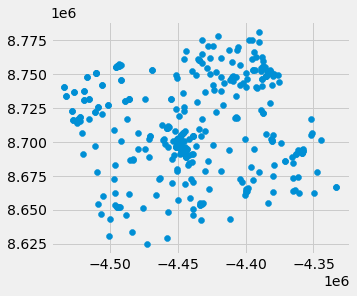

In [741]:
data_pos_bor_impl["Coord_geo_borne"].plot() # visualisation des bornes déjà installées

In [742]:
#A
data_pos_bor_impl_1 = pd.pivot_table(data_pos_bor_impl,index=["id_commune","puissance_nominale"],values=["puissance_nominale"],aggfunc="count").reset_index()

In [417]:
data_pos_bor_impl_1.head()

id_commune puissance_nominale  Coord_geo_borne
0     14658.0                 22                1
1     22014.0              22000                1
2     22020.0              22000                2
3     22021.0              22000                1
4     22026.0              22000                1

In [749]:
data_pos_bor_impl_1.shape

(226, 3)

In [748]:
data_pos_bor_impl_1.id_commune.nunique()

189

**Fusion de la base "bornes déjà installées avec les autres**

In [750]:
data_pos_bor_impl_1.rename(columns = {'Coord_geo_borne':'Nombre_de_bornes'}, inplace = True)

In [751]:
join_3 = pd.merge(join_2,data_pos_bor_impl_1,how="left")

In [752]:
join_3["puissance_nominale"][join_3["puissance_nominale"].isnull()]=0

C:\Users\a\AppData\Local\Temp\ipykernel_1072\3263147741.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [753]:
join = join_3.dropna()

In [754]:
join_dec = join[['id_troncon',"nb_bornes_pot","puissance_nominale","dens_pop","geometry",'Nombre_de_bornes']]

**Transformation des données pour l'ajustement du modèle**

In [755]:
join_dec.drop_duplicates()

id_troncon  nb_bornes_pot puissance_nominale   dens_pop  \
4686           78            4.0              22000  211.26125   
4687           78            4.0              22000  211.26125   
4688       161503            4.0              22000  211.26125   
4689       161505            2.0              22000  211.26125   
4690       161506            2.0              22000  211.26125   
...           ...            ...                ...        ...   
77459      174661           13.0              22000  384.02750   
77460      174661           13.0                 22  384.02750   
77461      174661           13.0              22000  384.02750   
77462      174662            7.0                 22  384.02750   
77463      174662            7.0              22000  384.02750   

                                                geometry  Nombre_de_bornes  
4686   LINESTRING (-4452762.338 8751688.789, -4452813...               1.0  
4687   LINESTRING (-4452829.198 8751788.021, -4452870...               1.0  
4688   LINESTRING (-4449702.105 8749554.072, -4449702...               1.0  
4689   LINESTRING (-4449702.041 8749542.312, -4449701...               1.0  
4690   LINESTRING (-4449713.139 8749671.758, -4449710...               1.0  
...                                                  ...               ...  
77459  LINESTRING (-4437803.617 8689450.186, -4437800...               1.0  
77460  MULTILINESTRING ((-4437726.776 8689415.155, -4...               2.0  
77461  MULTILINESTRING ((-4437726.776 8689415.155, -4...               1.0  
77462  LINESTRING (-4437799.248 8689409.796, -4437807...               2.0  
77463  LINESTRING (-4437799.248 8689409.796, -4437807...               1.0  

[7491 rows x 6 columns]

Les coordonnées géographiques des trançons ne sont pas tous dans le méme format. certains sont de type *LINESTRING* et d'autres de type *MultiLINESTRING* qui est un ensemble de *LINESTRING*. Le code ci-dessous permet de les remettre tous dans le même format.

In [431]:
df_explode=join_dec.explode(ignore_index=True) #explosion des multilines

In [432]:
df_explode.head()

id_troncon  nb_bornes_pot puissance_nominale   dens_pop  Nombre_de_bornes  \
0          78            4.0              22000  211.26125               1.0   
1          78            4.0              22000  211.26125               1.0   
2      161503            4.0              22000  211.26125               1.0   
3      161505            2.0              22000  211.26125               1.0   
4      161506            2.0              22000  211.26125               1.0   

                                            geometry  
0  LINESTRING (-4452762.338 8751688.789, -4452813...  
1  LINESTRING (-4452829.198 8751788.021, -4452870...  
2  LINESTRING (-4449702.105 8749554.072, -4449702...  
3  LINESTRING (-4449702.041 8749542.312, -4449701...  
4  LINESTRING (-4449713.139 8749671.758, -4449710...

On extrait à présent les coordonnées géographiques dans un format facilement manipulable pour la modélisation.

In [434]:
x_1 = []
x_2 = []
for i in tqdm(range(df_explode.shape[0])):
  x ,y = df_explode["geometry"][i].xy
  x_,y_ = list(x), list(y)
  x_1.append(np.mean(x_))
  x_2.append(np.mean(y_))

  0%|          | 0/287683 [00:00<?, ?it/s]

In [435]:
df_explode["x_1"]=x_1
df_explode["x_2"]=x_2

In [436]:
df_explode.drop("geometry",axis=1,inplace=True)  # suppression de la variable geometry

In [437]:
df_explode.head()

id_troncon  nb_bornes_pot puissance_nominale   dens_pop  Nombre_de_bornes  \
0          78            4.0              22000  211.26125               1.0   
1          78            4.0              22000  211.26125               1.0   
2      161503            4.0              22000  211.26125               1.0   
3      161505            2.0              22000  211.26125               1.0   
4      161506            2.0              22000  211.26125               1.0   

            x_1           x_2  
0 -4.452788e+06  8.751728e+06  
1 -4.452850e+06  8.751764e+06  
2 -4.449702e+06  8.749548e+06  
3 -4.449702e+06  8.749505e+06  
4 -4.449707e+06  8.749637e+06

Pour terminer, on aggrère les données par  l'identifiant du trançons.

In [756]:
X = pd.pivot_table(df_explode,index="id_troncon",values=['nb_bornes_pot', 'puissance_nominale', 'dens_pop',
       'Nombre_de_bornes', 'x_1', 'x_2']).reset_index()

In [758]:
X.head()

id_troncon  Nombre_de_bornes   dens_pop  nb_bornes_pot           x_1  \
0          78               1.0  211.26125            4.0 -4.452819e+06   
1          88               1.0  166.64125            1.0 -4.397855e+06   
2         200               1.0   81.47000            2.0 -4.408009e+06   
3         232               1.0  154.37750            8.0 -4.440151e+06   
4         233               1.0  154.37750            2.0 -4.440062e+06   

            x_2  
0  8.751746e+06  
1  8.750304e+06  
2  8.736416e+06  
3  8.683398e+06  
4  8.683516e+06

Le jeu de données ci-dessous toutes nos variables d'intérêt pour la modélisation c'est à dire:
- i_d_trancon :  l'idée du tronçon
- Nombre_de_bornes : déjà installé sur ce trançons où à c'est aléatour
- dens_pop : densité de la population aux alentours
- nb_bornes : Nombres de bornes qu'ont peut installer sur ce trançon

In [759]:
XX=X.iloc[:,1:].to_numpy() # convertion en tableau numpy

### Partie 2 : Moélisation à l'aide de l'Algorithme Basés sur la pondération de variables explicatives

Pour la modélisation nous utilisons un algorithme de Kmeans basés sur la pondération de variables explicatives. Cela ressemble à la méthode de kmeans standards mais la différence se situe au poids accordées à chaque observations.

Dans notre cas les poids sont calculés grâce au différentes variables qui jouent un grand rôle dans la décision d'implanter ou pas une borne de recharches.

Pour résumer l'algorithme utilisé est le suivant : 

- Choisir $𝑘$ et $𝛼_1$ , $𝛼_2$, $𝛼_3$, $𝛼_4$
- Pondération des tronçons $𝛼_1 𝑊_1 + 𝛼_2 𝑊_2+ 𝛼_3 𝑊_3$
- Algorithme de Kmeans avec $W$ associées aux tronçons et les coordonnées géographiques comme variable principale
- Choix du nombre optimal de $k$
- Récupération des centroïde comme localization des bornes de recharges





In [715]:

# Algorithme de Kmeans pondérées
class Kmeans:
    """
    """
    def __init__(self, X, k, alpha,col):
        self.X = X
        self.k = k
        self.alpha = alpha
        self.col=col

    def weights(self):
        """poids relatifs des variables"""
        poids_individus = []
        XX = self.X[:, self.col]
        X = XX / np.sum(XX, axis=0)
        if np.sum(self.alpha) == 1:
            for i in range(X.shape[0]):
               # individu = X[:, i]
                poids_individu = 0
                for j in range(X.shape[1]):
                    poids_individu +=X[i, j] * self.alpha[j]
                poids_individus.append(poids_individu)
        else:
            raise Exception('the sum of apha must be egal to 1')
        return poids_individus

    def get_weights(self):
        self.weights = self.weights()
        return self.weights 
     

    def fit(self, X, y=None):
        self.kmeans = KMeans(n_clusters=self.k, init='k-means++')
        if y is None:
            model = self.kmeans.fit(X, sample_weight=self.weights)
        else:
            model = self.kmeans.fit(X, y, sample_weight=self.weights)
        return model
    
    def get_cluster_centers(self):
        return self.kmeans.cluster_centers_
    
    def get_labels(self):
        return self.kmeans.labels_
    
    def get_inertia(self):
        return self.kmeans.inertia_

**Choix de la valeurs de K**

Pour le choix de la valeur de k, on utilise le score de silhouette.

In [760]:
from sklearn.metrics import silhouette_samples, silhouette_score,calinski_harabasz_score
import matplotlib.pyplot as plt

In [761]:
silhouette_coefficients = []
for k in range(100, 200):
    lod=Kmeans1(XX,k=k,alpha=[0.2,0.2,0.4,0.2],col=[0,1,2,3])
    lod.get_weights()
    lod.fit(XX[:,4:])
    score = silhouette_score(XX[:,4:], lod.get_labels())
    silhouette_coefficients.append(score)

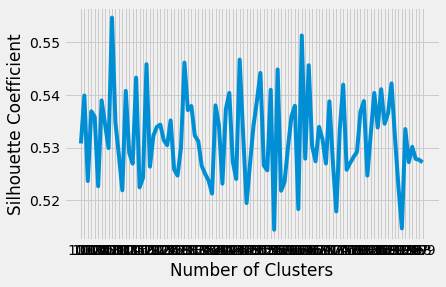

In [762]:
plt.style.use("fivethirtyeight")
plt.plot(range(100,200), silhouette_coefficients)
plt.xticks(range(100, 200))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [766]:
liste=list(range(100, 200))
liste[np.argmax(silhouette_coefficients)]

109

On va prendre, K=109 et on va accorper plus d'importance à la densité de population. c'est à dire $𝛼_3=1$.

In [768]:
k=109
lod=Kmeans(XX,k=k,alpha=[0,0,0,1],col=[0,1,2,3])

Voici les poids associées à chaque trançon.

In [770]:
lod.get_weights()

[0.0003864665963508179,
 0.0003816961740634995,
 0.0003825774567069798,
 0.0003853671650062869,
 0.00038535937628494786,
 0.000385369371287647,
 0.00038534991546403666,
 0.00038533763091165894,
 0.000385336590897422,
 0.00038533799318911794,
 0.000385334983695856,
 0.00038534174822103546,
 0.0003853388888265135,
 0.00038534093535304813,
 0.0003853437821759984,
 0.00038534962382775654,
 0.00038533902445784493,
 0.00038534313007101674,
 0.0003853430371349307,
 0.0003853386339583868,
 0.0003853354901525287,
 0.00038533475350066234,
 0.00038533193717905196,
 0.0003853334138019144,
 0.00038533698542678554,
 0.00038533556931421653,
 0.0003853345240555874,
 0.0003853392058539297,
 0.0003853384175004923,
 0.00038534333217336993,
 0.00038534201292667,
 0.00038534096974015083,
 0.00038533779189890667,
 0.000385339506777603,
 0.00038534305072261747,
 0.0003853344181060855,
 0.00038531136274706996,
 0.0003852106651719618,
 0.0003852102267472505,
 0.00038521153887065783,
 0.0003852067803802511,
 0.

In [771]:
lod.fit(XX[:,3:])
#lod.get_cluster_centers()

KMeans(n_clusters=109)

**Centres des clusters ( position des nouvelles de bornes de charges)**

In [772]:
from shapely import Point
import geopandas

In [773]:
center_cluster=lod.get_cluster_centers()

In [774]:
center_trans=[str(Point([center_cluster[i][0],center_cluster[i][1]])) for i in range(center_cluster.shape[0])]

In [775]:
df1 = geopandas.GeoDataFrame()
df1['geometry'] = geopandas.GeoSeries.from_wkt(center_trans)

In [776]:
data_pos_bor_impl.head() #ancienne borne

id_commune puissance_nominale                   Coord_geo_borne
0     35238.0                225  POINT (-4451456.541 8696709.615)
1     35238.0              22000  POINT (-4451161.417 8696158.699)
2     35238.0              22000  POINT (-4451242.026 8696360.885)
3     22105.0              22000  POINT (-4404262.135 8756603.802)
4     22082.0              22000  POINT (-4417968.644 8748144.409)

In [777]:
ANC = data_pos_bor_impl[["Coord_geo_borne"]]
ANC.rename({"Coord_geo_borne": "geometry"},inplace=True,axis=1)
NEW = df1[["geometry"]]

C:\Users\a\AppData\Local\Temp\ipykernel_1072\3972967479.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [728]:
BORNES =  pd.concat((ANC,NEW),axis=0)
anc=([1]*ANC.shape[0])
anc.extend([2]*NEW.shape[0])
BORNES["col"] = anc

C:\Users\a\anaconda3\lib\site-packages\geopandas\array.py:1406: UserWarning:

CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 43N (the single non-null crs provided).



In [778]:
cd=gpd.GeoDataFrame(BORNES)

In [779]:
BORNES.set_geometry("geometry")

geometry  col
0   POINT (-4451456.541 8696709.615)    1
1   POINT (-4451161.417 8696158.699)    1
2   POINT (-4451242.026 8696360.885)    1
3   POINT (-4404262.135 8756603.802)    1
4   POINT (-4417968.644 8748144.409)    1
..                               ...  ...
95  POINT (-4451361.426 8747852.724)    2
96  POINT (-4405484.591 8731802.423)    2
97  POINT (-4404675.031 8729301.114)    2
98  POINT (-4440194.469 8683054.631)    2
99  POINT (-4451645.970 8749659.930)    2

[454 rows x 2 columns]

<AxesSubplot:>

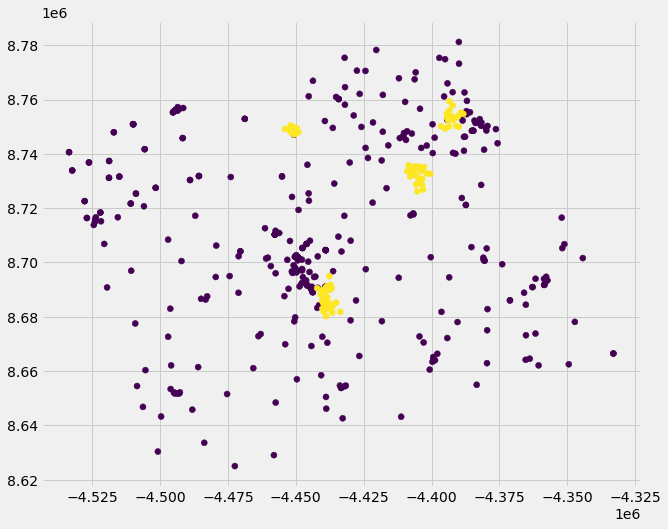

In [733]:
cd.plot(column="col", figsize=(12,8))

Les points en jaune, sont les emplacements des bornes et les points en violets representent les bornes déjà installées. Le tableau présentent les emplacements des bornes.

In [780]:
df1

geometry
0    POINT (-4392519.630 8753176.548)
1    POINT (-4438467.105 8687172.149)
2    POINT (-4451131.732 8748951.301)
3    POINT (-4405234.741 8734755.177)
4    POINT (-4438893.097 8690762.904)
..                                ...
104  POINT (-4408712.295 8735449.213)
105  POINT (-4407993.507 8734701.215)
106  POINT (-4438016.666 8690557.359)
107  POINT (-4405879.156 8729003.300)
108  POINT (-4393172.378 8753627.770)

[109 rows x 1 columns]